# Assignment 2 - GloVe : Global Vectors for Word Representation
Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd

## 1 Load Data
A real corpus

In [2]:
#Training Set
# Use corpus from nltk
import nltk
from nltk.corpus import brown
nltk.download('brown')
corpus_tokenized = nltk.corpus.brown.sents(categories='news')
len(corpus_tokenized)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Guntsv\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


4623

In [3]:
#1. tokenize
corpus_tokenized = [[word.lower() for word in sent] for sent in corpus_tokenized]
print(corpus_tokenized[:2])

[['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']]


In [4]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#adding unknown word
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

voc_size = len(vocabs)
voc_size

13113

In [5]:
#preparing all_vocabs
batch_size = 2

def prepare_seqeunce(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_seqeunce(list(vocabs),word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 13113])

In [6]:
index2word = {v:k for k,v in word2index.items()}
# index2word

## 2. Co-occurence Matrix X

Count the occurrences of pair of words using window size of 1 (you can use 2, 3, 4, up to you)

E.g., Dog loves to eat meal.

['Dog','loves',1],['loves','to',1]

In [7]:
#use Counter to first count stuffs
from collections import Counter
# print(corpus_tokenized)

#count the frequency of each word
#we somehow need this to claiclate the probability Pi
X_i = Counter(flatten(corpus_tokenized)) #merge all list ... (flattten is a function I defines)
# X_i['apple'] #get the probability of apple

In [8]:
skip_grams = []
cbows = []
window_size = 2
#for each corpus
for sent in corpus_tokenized:
    for i in range(1,len(sent)-window_size): #start from 2 to second last
        context_word = []
        # print(sent[i])
        center_word = sent[i]
        for j in range(window_size):
            outside_word = [sent[i-j-1],sent[i+j+1]] #window_size adjustable
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                context_word.append(o)
                skip_grams.append((center_word,o))
            cbows.append((context_word,center_word))

In [9]:
#since we have these occcurences, we can count, to make our co-occurence matrix!!!
X_ik_skipgram = Counter(skip_grams)
# X_ik_skipgram

## 3. Weighting function f

GloVe includes a weighting function to scale down too frequent words.

In [10]:
def weighting(w_i,w_j,X_ik): #we need w_i and w_j, because we can try its-co-occurrences, if it's too big, we scale it down
    #check whether the co-occurrences between these two word exits??
    try:
        x_ij = X_ik[(w_i,w_j)]
    except:
        x_ij = 1 #why one, so that the probability thingly won't break....
    
    #maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75

    #if the co-occurrences does not exceed x_max, cale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1 #this is the maximum probability you can havve
    
    return result

In [11]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} #for keeping the co-occurrences
weighting_dic = {} #for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs,2): #we need to also think its reverse
    # print(bigram)
    #if this bigram exists in X_ik_skipgrams
    #we gonna add this to our c-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram] #get the co-occurrences
        X_ik[bigram] = cooc + 1 #this is agian basically label smoothing.... (stability issue (especailly when divide something))
        X_ik[(bigram[1],bigram[0])] = cooc + 1 #trick to get all pairs
    else: #otherwise, do nothing
        pass
    #apply the weighting function using this co-occurrence matrix thingly
    weighting_dic[bigram] = weighting(bigram[0],bigram[1],X_ik)
    weighting_dic[(bigram[1],bigram[0])] = weighting(bigram[1],bigram[0],X_ik)

## 4. Prepare train data
You move the window along, and create those tuples as we said in class


<img src = "figures/glove_weighting_func.png" width=400>

In [12]:
import math

def random_batch(batch_size,word_sequence,skip_grams,X_ik,weighting_dic):
    #loop through skipgram, and change it id because when sending model, it must number 
    skipg_grams_id = [(word2index[skip_gram[0]],word2index[skip_gram[1]]) for skip_gram in skip_grams]
    #randomly pick 'batch_size' indexes
    number_of_choices = len(skipg_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among  these random indexes
    
    # print(random_index)
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #xij (in batches)
    random_weighting = [] #f(xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skipg_grams_id[i][0]]) #same reason why I put bracket here....
        random_labels.append([skipg_grams_id[i][1]])

        #get coocs
        #first check whether it exists.....
        pair = skip_grams[i] #e.g., ['banana','fruit']
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing

        random_coocs.append([math.log(cooc)]) #1. why log, #2 why bracket -> size ==> (,1) #my neural network excepts (,1)
        
        #for weighting
        weighting = weighting_dic[pair] #why not user try... maybe it does not exist
        random_weighting.append(weighting)

    return np.array(random_inputs),np.array(random_labels),np.array(random_coocs),np.array(random_weighting)
        #return xi,xj
        #return cooc Xij
        #return weighting

In [13]:
batch_size = 2
input, target, coocs, weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)

In [14]:
input, target, coocs, weightin

(array([[2169],
        [7167]]),
 array([[2363],
        [3174]]),
 array([[1.09861229],
        [1.09861229]]),
 array([0.07208434, 0.07208434]))

## 5. Model

<img src ="figures/glove.png">

In [15]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vectos for outside words
#v_C - vector for center word
#u_w - vectors of all vocabs

class GloVe(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(GloVe,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        
        self.bias_i = nn.Embedding(voc_size, 1)
        self.bias_j = nn.Embedding(voc_size, 1)
    def forward(self, center_words, outside_words, coocs, weighting):
        #get the embedding of center_words and outside_words
        center_embeds = self.embedding_center_word(center_words)
        outside_embeds = self.embedding_outside_word(outside_words)

        #create biases #create unique embedding (voc_size,1)
        inner_product = center_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        bias_i = self.bias_i(center_words).squeeze(1) #center
        bias_j = self.bias_j(outside_words).squeeze(1) #target
        #do the product between wi and wj
        loss = weighting * torch.pow(inner_product + bias_i + bias_j - coocs, 2)
        
        return torch.sum(loss)

# 6. Training

In [16]:
voc_size = len(vocabs)
batch_size = 2 #why? no reason
emb_size = 50 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = GloVe(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
import time
num_epochs = 5000
#for epoch
start_time = time.time()
for epoch in range(num_epochs):
    #get random batch
    input, label, cooc, weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)
    input_batch = torch.LongTensor(input)
    label_batch = torch.LongTensor(label)
    cooc_batch = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)

    # print(input_batch.shape,label_batch.shape,cooc_batch.shape,weightin_batch.shape)

    #loss = model
    loss = model(input_batch,label_batch,cooc_batch,weightin_batch)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1} | Loss {loss:.6f} | Time : {epoch_mins}m {epoch_secs}s')
    torch.save(model.state_dict(), "./model/GloveModel.pth")
    # break

Epoch 1000 | Loss 424.851501 | Time : 1m 49s
Epoch 2000 | Loss 592.275452 | Time : 3m 29s
Epoch 3000 | Loss 57.981087 | Time : 5m 22s
Epoch 4000 | Loss 175.317627 | Time : 7m 5s
Epoch 5000 | Loss 15437.078125 | Time : 8m 47s


In [57]:
torch.save(model.state_dict(), "./model/GloveModel.pth")

In [59]:
import pickle
with open('./model/GloveModel.pkl','wb') as f:
    pickle.dump(model,f)

In [61]:
with open('./model/GloveModel.pkl','rb') as f:
    model_test = pickle.load(f)

## 7. Plotting the embeddings

Is really the related studd are close to each other, and vice versa.

The most fun part: Will 'banana' closer to 'fruit' than 'cat'?

In [19]:
#find embedding of fruit, cat
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return np.array(embed[0].detach().numpy())
    # return embed[0][0].item(),embed[0][1].item()

In [ ]:
# Cannot plot due to embeddding size is 50
# #help me plot on maplotlib
# plt.figure(figsize=(10,10))
# for i, word in enumerate(vocabs[:100]):
#     x,y = get_embed(word)
#     plt.scatter(x,y)
#     plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
# plt.show()

## 8. Evaluation 

### 8.1 Cosine Similarity
How do (from Scratch) calcualte cosine similarity?

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [20]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [21]:
#let's try similarity between first and second, and second and third
Athens = get_embed('athens')
Greece = get_embed('greece')
Iraq = get_embed('iraq')
print(f"Athens vs. Greece: ",cos_sim(Athens, Greece))
print(f"Greece vs. Iraq: ",cos_sim(Greece, Iraq))

Athens vs. Greece:  -0.21558218
Greece vs. Iraq:  -0.21558218


### 8.2 Prediction 
- does the Work analogy task : a is b as c is to ______

In [118]:
#Testing Set
nlp = spacy.load('./en_core_web_sm/')
text = open('./dataset/questions-words.txt',mode='r')
df = pd.DataFrame(text.readlines())
df.shape

(19558, 1)

In [119]:
#Check Header 
header = df[0].str.startswith(':')
index_list = np.where(header)[0].tolist()
print(index_list)

[0, 507, 5032, 5899, 8367, 8874, 9867, 10680, 12013, 13136, 14193, 15793, 17354, 18687]


In [120]:
#Remove Header
#format drop(index,inplace=True)
# df.drop(index_list, inplace=True)
# df.shape

In [121]:
df = df[8875:9867]
df

,0
8875,amazing amazingly apparent apparently\n
8876,amazing amazingly calm calmly\n
8877,amazing amazingly cheerful cheerfully\n
8878,amazing amazingly complete completely\n
8879,amazing amazingly efficient efficiently\n
...,...
9862,usual usually slow slowly\n
9863,usual usually sudden suddenly\n
9864,usual usually swift swiftly\n
9865,usual usually typical typically\n


In [113]:
df.shape

(992, 1)

In [114]:
def clean_data(df_col):
    corpus = []
    for item in df_col:
        item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus

In [115]:
#1. tokenize
#data cleaned
corpus_test = clean_data(df[0])
#data tokenized
corpus_tokenized_test = [sent.split(" ") for sent in corpus_test]
corpus_tokenized_test[:5]

[['amazing', 'amazingly', 'apparent', 'apparently'],
 ['amazing', 'amazingly', 'calm', 'calmly'],
 ['amazing', 'amazingly', 'cheerful', 'cheerfully'],
 ['amazing', 'amazingly', 'complete', 'completely'],
 ['amazing', 'amazingly', 'efficient', 'efficiently']]

In [87]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs_test = list(set(flatten(corpus_tokenized_test)))


#2.2 assign id to all these vocabs
word2index_test = {v: idx for idx, v in enumerate(vocabs_test)}

#adding unknown word
vocabs.append('<UNK>')
word2index_test['<UNK>'] = len(vocabs_test) - 1

voc_size_test = len(vocabs_test)
voc_size_test

64

In [88]:
#find embedding of fruit, cat
def get_embed_test(word):
    try:
        index = word2index_test[word]
    except :
        index = word2index_test['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model_test.embedding_center_word(word)+model_test.embedding_outside_word(word))/2
    return np.array(embed[0].detach().numpy())
    # return embed[0][0].item(),embed[0][1].item()

In [101]:
def find_analogy(a,b,c):
    emb_a, emb_b, emb_c = get_embed_test(a),get_embed_test(b),get_embed_test(c)
    vector = emb_b - emb_a + emb_c
    # vector_norm = (vector ** 2).sum() ** (1 / 2)
    # vector = vector / vector_norm
    # print(vector.shape)
    similarity = -1 
    
    for vocab in vocabs_test:
        if vocab not in [a,b,c]: #ignore input words itself
            index = word2index_test[vocab]
            word = torch.LongTensor([index])
            current_sim = cos_sim(vector,get_embed_test(word))
            if current_sim > similarity:
                similarity = current_sim #update better one
    return vocab, similarity

In [102]:
find_analogy('athens','greece','Bangkok')

('quick', 1.0)

## Testing

### create dataset

In [103]:
data = pd.DataFrame(corpus_tokenized_test, columns=["A", "B", "C", "D"])
data.head()

,A,B,C,D
0,amazing,amazingly,apparent,apparently
1,amazing,amazingly,calm,calmly
2,amazing,amazingly,cheerful,cheerfully
3,amazing,amazingly,complete,completely
4,amazing,amazingly,efficient,efficiently


In [104]:
def analogy_accuracy(data): #testing 
    corrects = 0
    total = len(data)
    for idx, row in data.iterrows():
        a, b, c, d = row['A'],row['B'],row['C'],row['D']
        predict = find_analogy(a,b,c)[0] 
        if predict == d: 
            corrects +=1 
    acc = corrects/total
    return acc

In [105]:
analogy_accuracy(data)

0.0

### 8.3 PCA Plotting

In [106]:
subset = [get_embed(vocab) for vocab in vocabs_test]

In [107]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit(subset).transform(subset)
reduced = pd.DataFrame(reduced,columns=['X','Y'])
reduced['word'] = vocabs_test #adding columns
reduced.head()

,X,Y,word
0,2.061358,0.252657,rapid
1,-2.535856,-0.102223,cheerful
2,1.475336,0.173250,free
3,0.006217,0.523603,quickly
4,1.254136,-1.610836,usual


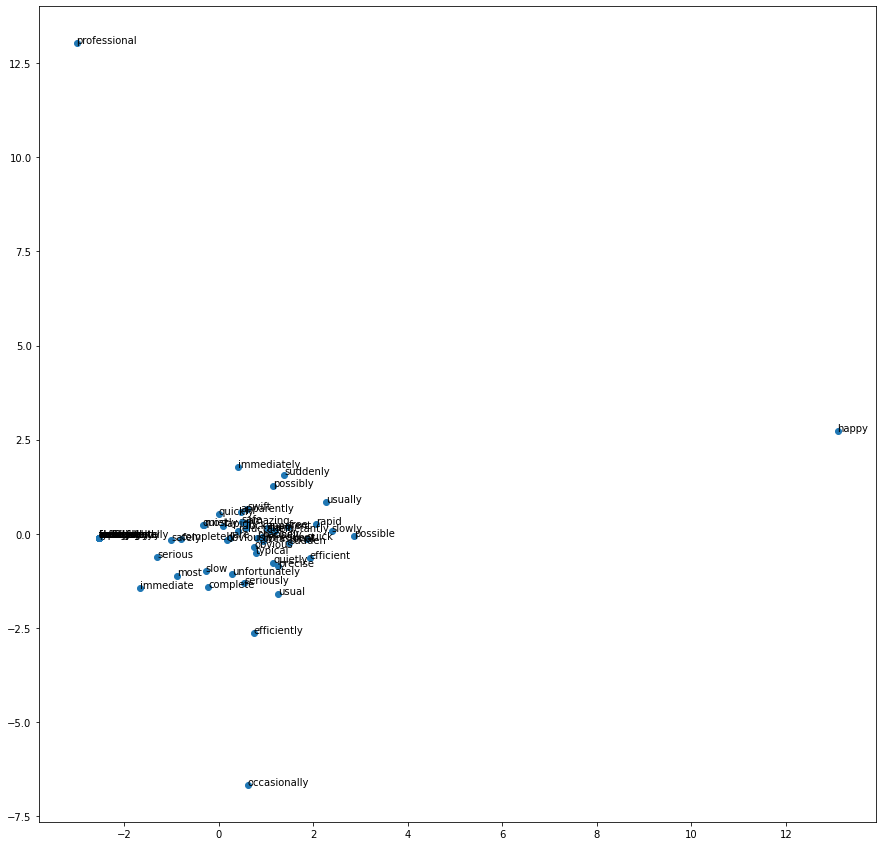

In [108]:
plt.figure(figsize=(15,15))
plt.scatter(x=reduced['X'],y=reduced['Y'])
for idx, value in reduced.iterrows():
    plt.annotate(reduced['word'][idx],value[:-1])

## Conclusion